In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# месячное скользящее окно
window = 21

# макс KPSS статистика (95% critical value)
KPSS_max = 0.463

# параметры стратегии - коммиссии, отпимальный вход и стоп-лосс
fee = 0.001
entry = 0.02
stop_loss = -0.05

# начинаем с кэша
signal = 0
current_return = 0
position0 = 0
position1 = 0

# обозначаем наш сэмпл
start = '2019-01-04'
end = '2021-08-07'

# торговая пара
tickers = ['IMMP','SYPR']
# индекс S&P500
market = '^GSPC'

# вводим массивы
gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
raw_data = pd.DataFrame()

tickers_data = pd.DataFrame()
market_data = pd.DataFrame()
market_data['market'] = yf.download(market, start, end)['Close']

[*********************100%***********************]  1 of 1 completed


In [3]:
df6_test = pd.read_csv('df6_tot_test.csv', index_col = 'date')
for ticker in tickers:
    tickers_data[ticker] = df6_test[ticker]
tickers_data.index = tickers_data.index.astype('datetime64[ns]')
raw_data = pd.concat([tickers_data, market_data], axis=1)
print(np.where(raw_data.isna()))
raw_data

(array([], dtype=int64), array([], dtype=int64))


,IMMP,SYPR,market
2019-01-03,2.0500,0.9800,2447.889893
2019-01-04,2.1500,0.9700,2531.939941
2019-01-07,2.1500,0.9311,2549.689941
2019-01-08,2.1399,0.9800,2574.409912
2019-01-09,2.1800,0.9849,2584.959961
...,...,...,...
2021-08-02,3.4600,3.0700,4387.160156
2021-08-03,3.5800,3.0300,4423.149902
2021-08-04,3.5900,3.0400,4402.660156
2021-08-05,3.7400,3.0900,4429.100098


In [4]:
spread_stats = []
b_opts = []
# проводим по циклу наш сэмпл 
for t in range(window, len(raw_data)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    # обозначим наш подсэмпл
    data = raw_data[t-window:t]
    #stock 2 = (a=0) + b*stock 1 
    # стартовые параметры OLS
    reg = sm.OLS(np.array(data[tickers[1]]), np.array(data[tickers[0]]))
    res = reg.fit()
    b0 = res.params[0]
    
    # функция KPSS одно-параметрическая
    def KPSS(b):
        resid = np.array(data[tickers[1]] - (b*data[tickers[0]]))
        cum_resid = np.cumsum(resid)
        st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
        KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
        return KPSS
    # минимизируем KPSS функцию (максимизируем стационарность)
    res = spop.minimize(KPSS, b0, method='Nelder-Mead')
    KPSS_opt = res.fun
    # наши оптимальные параметры
    b_opt = float(res.x)
    if (len(b_opts) > window) and (abs(b_opt - np.mean(b_opts)) > 3*np.std(b_opts)):
        b_opt = b_opts[-1]
    #print('OLS_opt: ', np.round(b_opt, 2), np.round(a_opt, 2))
    # симуляция торгов
    # сначала проверим не сработал ли стоп-лосс
    spread = raw_data[tickers[1]][t] - (b_opt*raw_data[tickers[0]][t])
    returns = raw_data[tickers[1]][t]/(b_opt*raw_data[tickers[0]][t])-1
    if current_return < stop_loss:
        signal = 0
        #print('stop-loss triggered')
    # если мы уже в позиции, проверим произошел ли возврат к среднему, продолжаем держать, если нет.
    elif np.sign(spread) == old_signal:
        singal = old_signal
    else:
        # торгуем только если есть коинтеграция
        if KPSS_opt > KPSS_max:
            signal = 0
        # тогруем только если есть существенное отклонение от средней
        elif abs(returns) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (b_opt*raw_data[tickers[0]][t]))
    # считаем доходность стратегии
    position0 = signal
    position1 = -signal
    # считаем доходность
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - b_opt*fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    # заполняем массивы
    b_opts.append(b_opt)
    spread_stats.append(spread)
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)

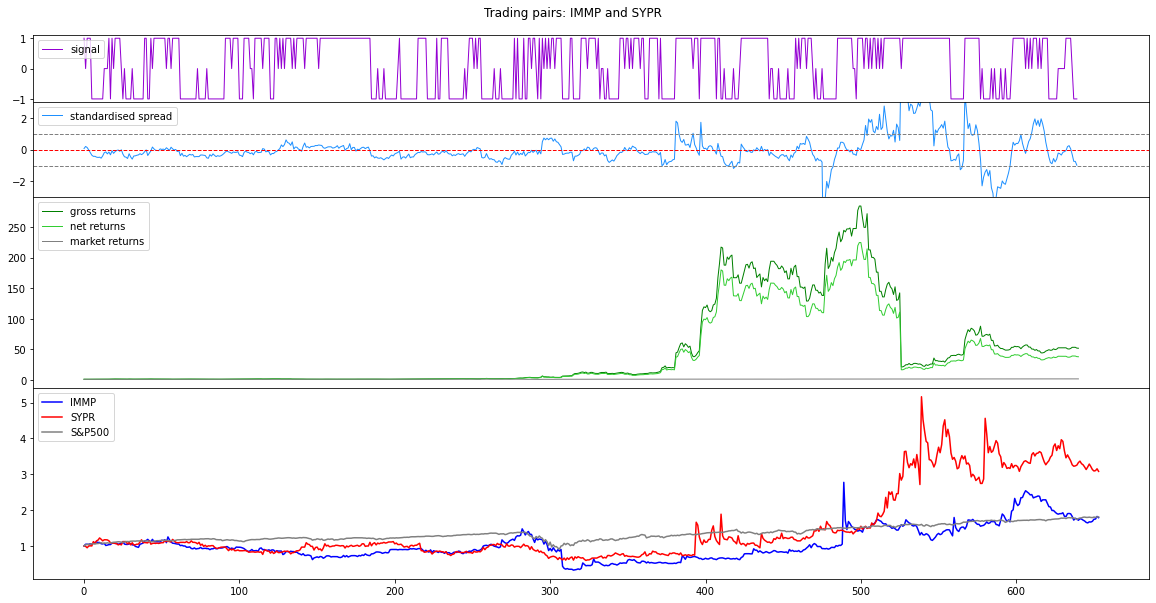

In [5]:
def zscore(series):
    return (series - np.mean(series)) / np.std(series)
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(4, hspace=0, height_ratios=[0.7, 1, 2, 2])
axs = gs.subplots(sharex=True)
fig.suptitle('Trading pairs: ' + str(tickers[0]) + ' and ' + str(tickers[1]), y=0.92)

axs[0].plot(signals, lw=1, label='signal', c='darkviolet')

axs[1].plot(zscore(spread_stats), lw=1, label='standardised spread', c='dodgerblue')
axs[1].axhline(y=1, xmin=0, xmax=1, linestyle='--', color='grey', lw=1)
axs[1].axhline(y=0, xmin=0, xmax=1, linestyle='--', color='r', lw=1)
axs[1].axhline(y=-1, xmin=0, xmax=1, linestyle='--', color='grey', lw=1)
axs[1].set_ylim((-3, 3))

axs[2].plot(np.append(1,np.cumprod(1+gross_returns)), lw=1, label='gross returns', c='green')
axs[2].plot(np.append(1,np.cumprod(1+net_returns)), lw=1, label='net returns', c='limegreen')
axs[2].plot(np.append(1,np.cumprod(1+market_returns)), lw=1, label='market returns', c='gray')


axs[3].plot(np.array(raw_data[tickers[0]]/raw_data[tickers[0]][0]), label=tickers[0], color='blue')
axs[3].plot(np.array(raw_data[tickers[1]]/raw_data[tickers[1]][0]), label=tickers[1], color='red')
axs[3].plot(np.array(raw_data['market']/raw_data['market'][0]), label='S&P500', color='gray')
# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    ax.legend(loc='upper left')

### Вычислительный эксперимент

In [2]:
list0 = np.load('pump_and_dump/pairs_list0.npy', allow_pickle=True).tolist()
list1 = np.load('pump_and_dump/pairs_list1.npy', allow_pickle=True).tolist()
list2 = np.load('pump_and_dump/pairs_list2.npy', allow_pickle=True).tolist()

In [3]:
# загрузим сформированный датасет цен всех ликвидных акций
df6_test = pd.read_csv('df6_tot_test.csv')

In [16]:
def coint_trade(list0, w, df):
    cum_returns = []
    
    def KPSS(b):
        resid = np.array(data[tickers[1]] - (b*data[tickers[0]]))
        cum_resid = np.cumsum(resid)
        st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
        KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
        return KPSS
    
    for i in tqdm(range(len(list0))):
        tickers = list0[i]
        raw_data = pd.DataFrame()
        raw_data[tickers[0]] = df[tickers[0]]
        raw_data[tickers[1]] = df[tickers[1]]

        window = w
        KPSS_max = 0.463
        fee = 0.001
        entry = 0.02
        stop_loss = -0.05

        signal = 0
        current_return = 0
        position0 = 0
        position1 = 0
        b_opts = []
        net_returns = np.array([])

        for t in range(window, len(raw_data)-1):
            old_signal = signal
            old_position0 = position0
            old_position1 = position1
            data = raw_data[t-window:t]

            reg = sm.OLS(np.array(data[tickers[1]]), np.array(data[tickers[0]]))
            res = reg.fit()
            b0 = res.params[0]

            res = spop.minimize(KPSS, b0, method='Nelder-Mead')
            KPSS_opt = res.fun
            b_opt = float(res.x)
            if (len(b_opts) > window) and (abs(b_opt - np.mean(b_opts)) > 3*np.std(b_opts)):
                b_opt = b_opts[-1]

            spread = raw_data[tickers[1]][t] - (b_opt*raw_data[tickers[0]][t])
            returns = raw_data[tickers[1]][t]/(b_opt*raw_data[tickers[0]][t])-1

            if current_return < stop_loss:
                signal = 0
            elif np.sign(spread) == old_signal:
                singal = old_signal
            else:
                if KPSS_opt > KPSS_max:
                    signal = 0
                elif abs(returns) < entry:
                    signal = 0
                else:
                    signal = np.sign(spread)

            position0 = signal
            position1 = -signal

            gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
            net = gross - b_opt*fee*(abs(position0 - old_position0) + abs(position1 - old_position1))

            if signal == old_signal:
                current_return = (1+current_return)*(1+gross)-1
            else:
                current_return = gross
            
            b_opts.append(b_opt)
            net_returns = np.append(net_returns, net)
            
        net_returns_ = np.append(1,np.cumprod(1+net_returns))    
        cum_returns.append(net_returns_)
        
    return cum_returns

In [102]:
def plot_rets(cum_returns, scale='linear'):
    colormap = plt.cm.gist_ncar
    colors = [colormap(i) for i in np.linspace(0, 1,len(cum_returns))]
    plt.figure(figsize=(20, 8))
    for i, rets in enumerate(cum_returns):
        plt.plot(rets, lw=1, c=colors[i])
    plt.yscale(scale)
    plt.show()

### Cтандартное окно размером в 21 день для всех пар

#### 1. Топ-100 пар, когда как минимум на одном тестов Дики-Фуллера спред стационарен, а ccm, pc - максимальны.

In [21]:
cum_returns0 = coint_trade(list0, 21, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:02<00:00,  2.43s/it]


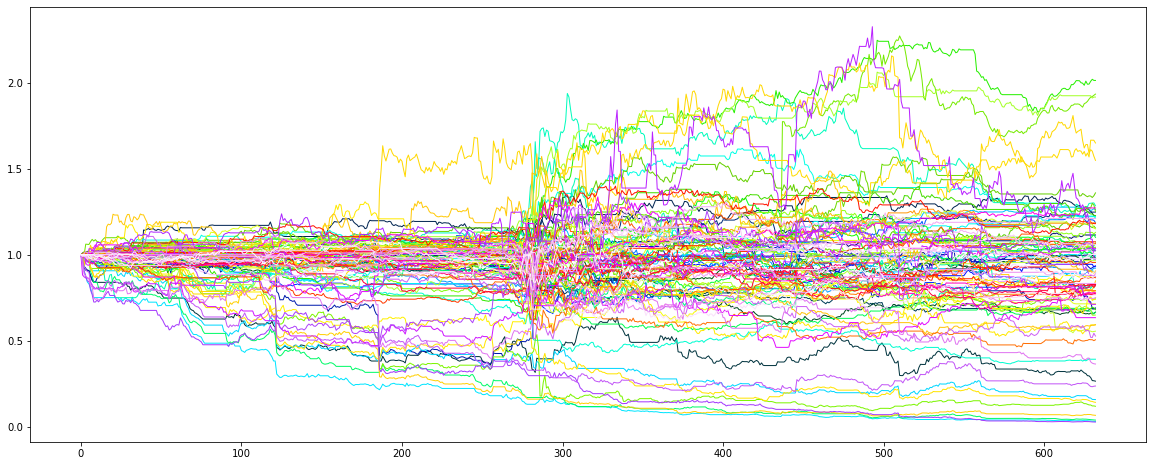

In [42]:
plot_rets(cum_returns0)

#### 2. Топ-100 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, а ccm и pc - максимальны.

In [23]:
cum_returns1 = coint_trade(list1, 21, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.46s/it]


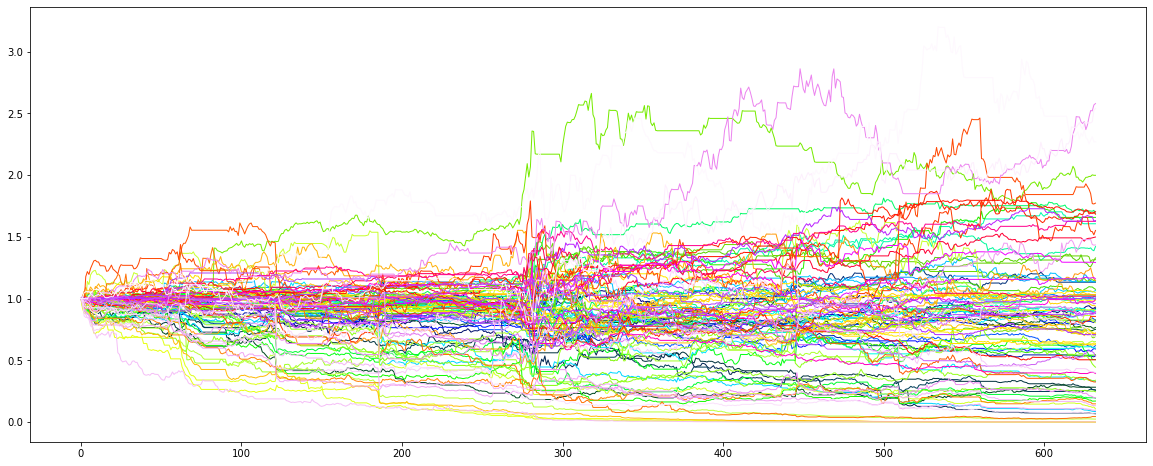

In [43]:
plot_rets(cum_returns1)

#### 3. Топ-100 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, ccm - минимально, а pc - максимально.

In [90]:
cum_returns2 = coint_trade(list2, 21, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:10<00:00,  2.51s/it]


In [146]:
outliers = np.unique(np.unique(np.where(np.array(cum_returns2)>50)[0]).tolist() + 
          np.unique(np.where(np.array(cum_returns2)<-1)[0]).tolist()).tolist()
new_rets_list = [j for i, j in enumerate(cum_returns2) if i not in outliers]
new_rets_list_f = [j for i, j in enumerate(cum_returns2) if i in outliers]

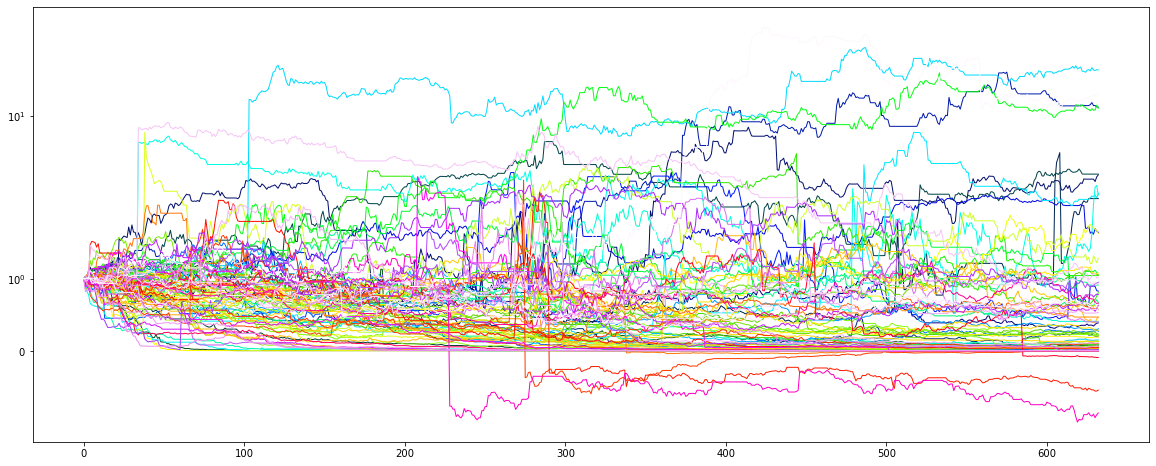

In [152]:
plot_rets(new_rets_list, scale='symlog')

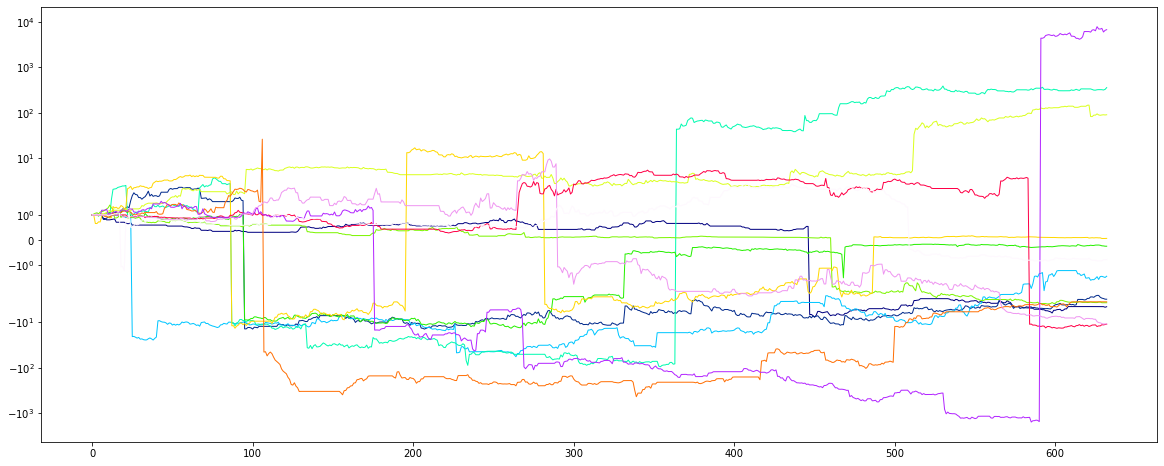

In [153]:
plot_rets(new_rets_list_f, scale='symlog')

In [149]:
total_return0 = np.sum(np.array(cum_returns0)[:,-1] - 1)
total_return1 = np.sum(np.array(cum_returns1)[:,-1] - 1)
total_return2_new_list = np.sum(np.array(new_rets_list)[:,-1] - 1)
total_return2_new_list_f = np.sum(np.array(new_rets_list_f)[:,-1] - 1)

In [150]:
total_return0, total_return1, total_return2_new_list, total_return2_new_list_f

(-10.40342044345238,
 -15.766003897812343,
 11.334632229007989,
 7154.705284233978)

In [185]:
#np.save('cum_returns0_coint_21.npy', cum_returns0)
#np.save('cum_returns1_coint_21.npy', cum_returns1)
#np.save('cum_returns2_coint_21.npy', cum_returns2)

### Cтандартное окно размером в 42 день для всех пар

#### 1. Топ-100 пар, когда как минимум на одном тестов Дики-Фуллера спред стационарен, а ccm, pc - максимальны.

In [140]:
cum_returns0_ = coint_trade(list0, 42, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:55<00:00,  2.36s/it]


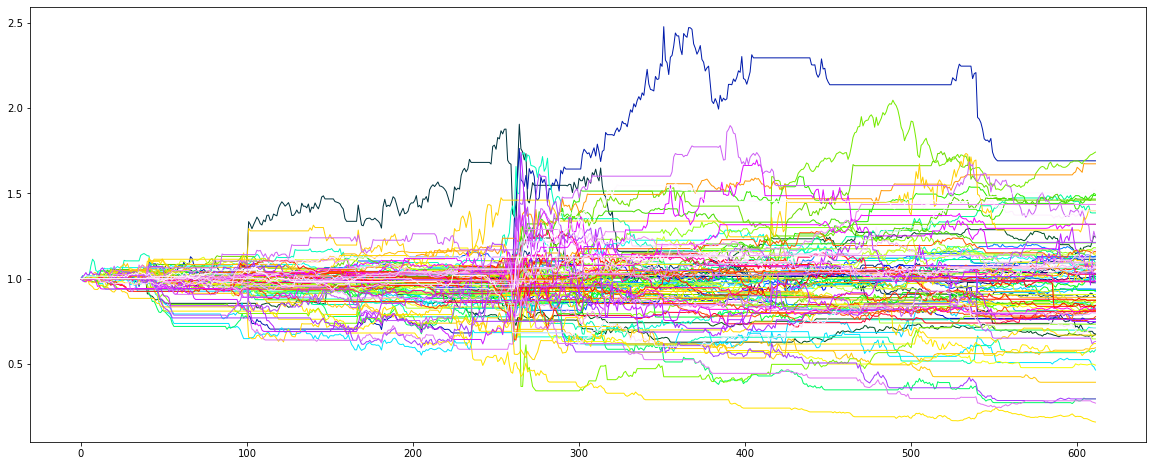

In [154]:
plot_rets(cum_returns0_)

#### 2. Топ-100 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, а ccm и pc - максимальны.

In [155]:
cum_returns1_ = coint_trade(list1, 42, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:00<00:00,  2.40s/it]


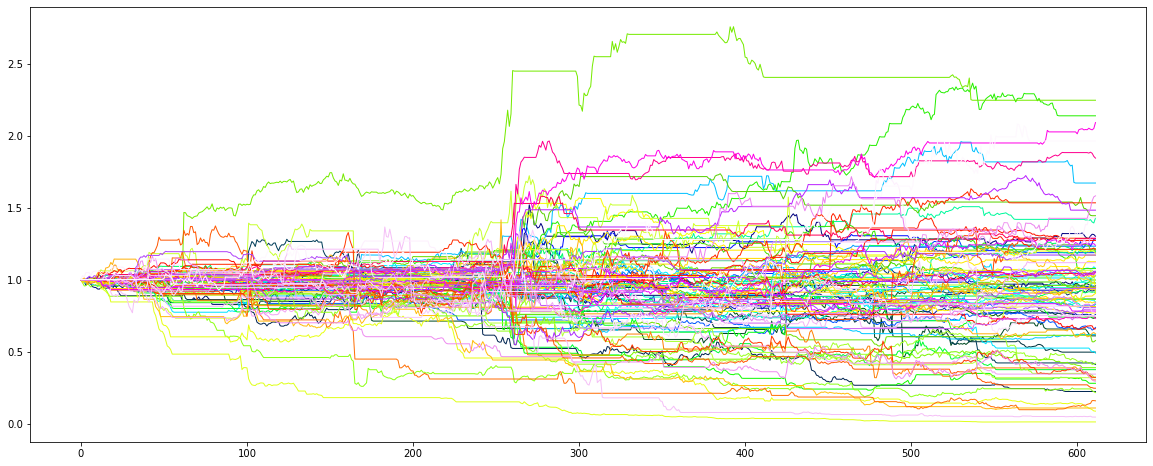

In [156]:
plot_rets(cum_returns1_)

#### 3. Топ-100 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, ccm - минимально, а pc - максимально.

In [157]:
cum_returns2_ = coint_trade(list2, 42, df6_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:06<00:00,  2.47s/it]


In [175]:
outliers_ = np.unique(np.unique(np.where(np.array(cum_returns2_)>40)[0]).tolist() + 
          np.unique(np.where(np.array(cum_returns2)<-2)[0]).tolist()).tolist()
new_rets_list_ = [j for i, j in enumerate(cum_returns2_) if i not in outliers_]
new_rets_list_f_ = [j for i, j in enumerate(cum_returns2_) if i in outliers_]

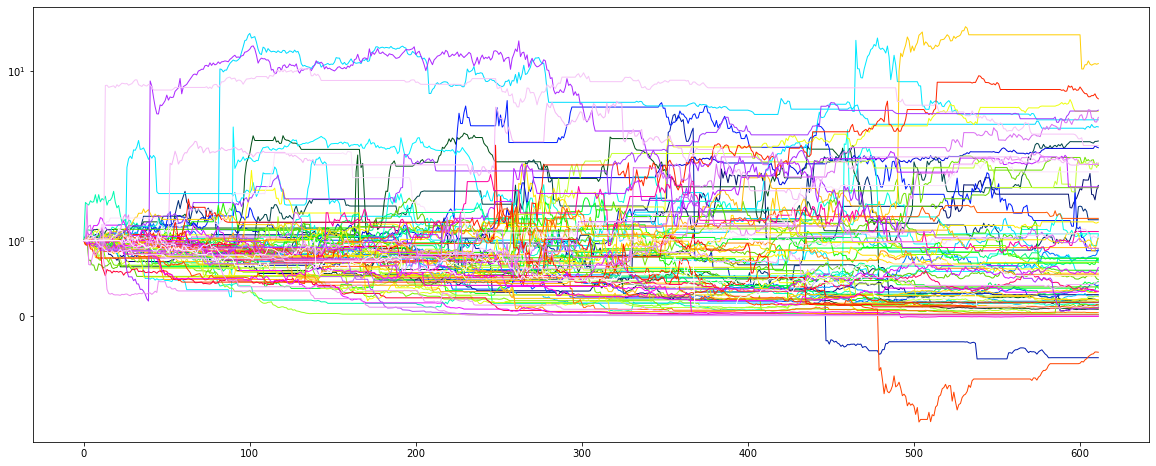

In [180]:
plot_rets(new_rets_list_, scale='symlog')

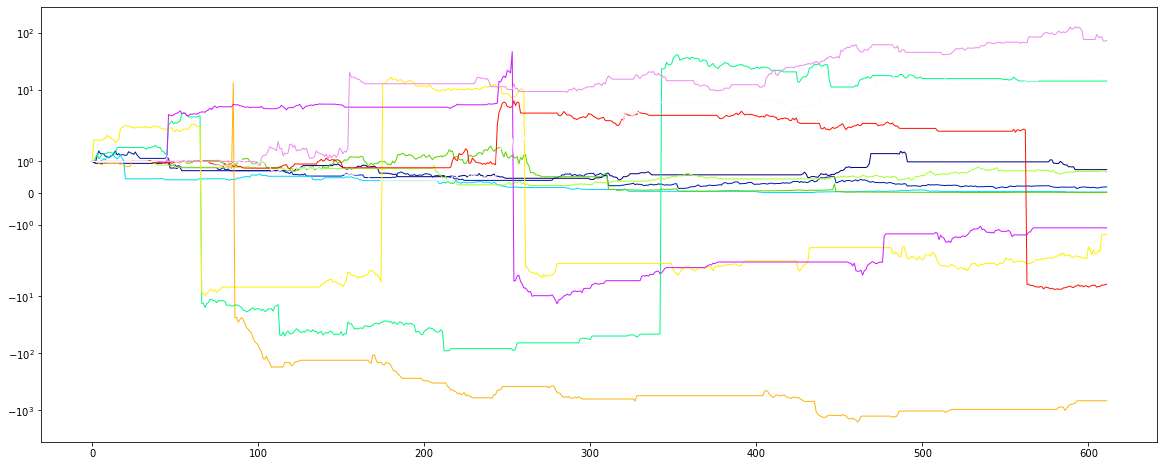

In [181]:
plot_rets(new_rets_list_f_, scale='symlog')

In [182]:
total_return0_ = np.sum(np.array(cum_returns0_)[:,-1] - 1)
total_return1_ = np.sum(np.array(cum_returns1_)[:,-1] - 1)
total_return2_new_list_ = np.sum(np.array(new_rets_list_)[:,-1] - 1)
total_return2_new_list_f_ = np.sum(np.array(new_rets_list_f_)[:,-1] - 1)

In [183]:
total_return0_, total_return1_, total_return2_new_list_, total_return2_new_list_f_

(-3.367360367965548,
 -8.977274750987279,
 3.4530868481810715,
 -588.4374012195628)

In [186]:
#np.save('cum_returns0_coint_42.npy', cum_returns0_)
#np.save('cum_returns1_coint_42.npy', cum_returns1_)
#np.save('cum_returns2_coint_42.npy', cum_returns2_)